## indexed by table 


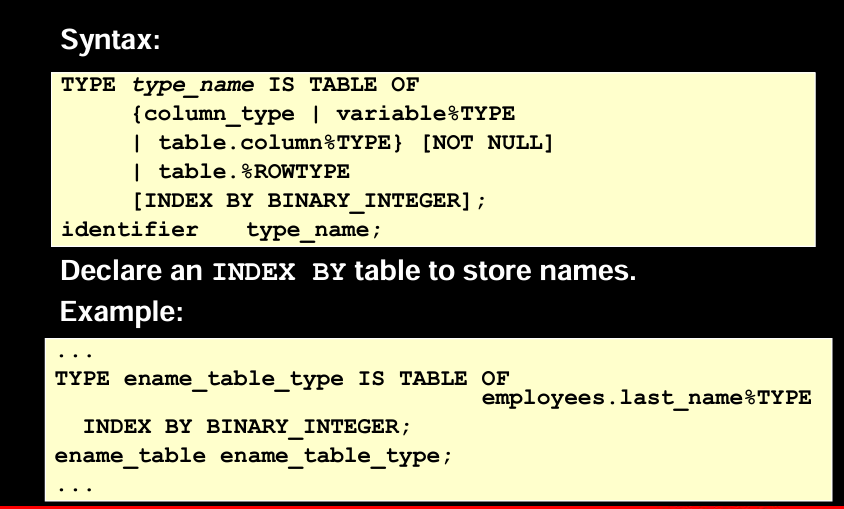
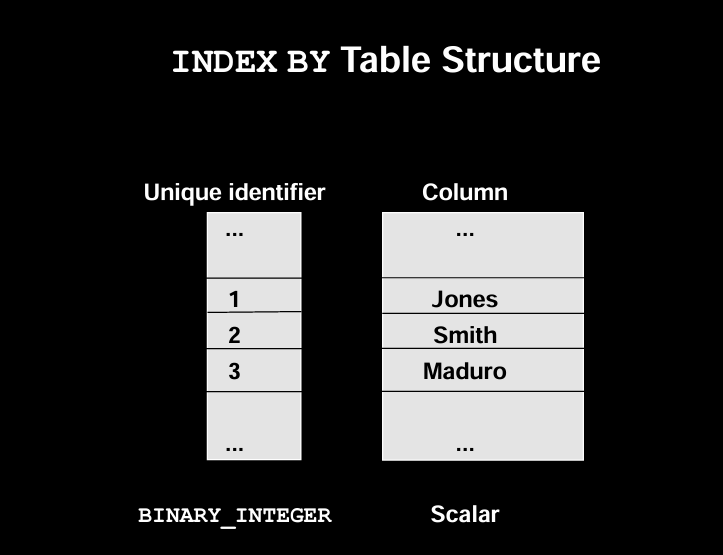
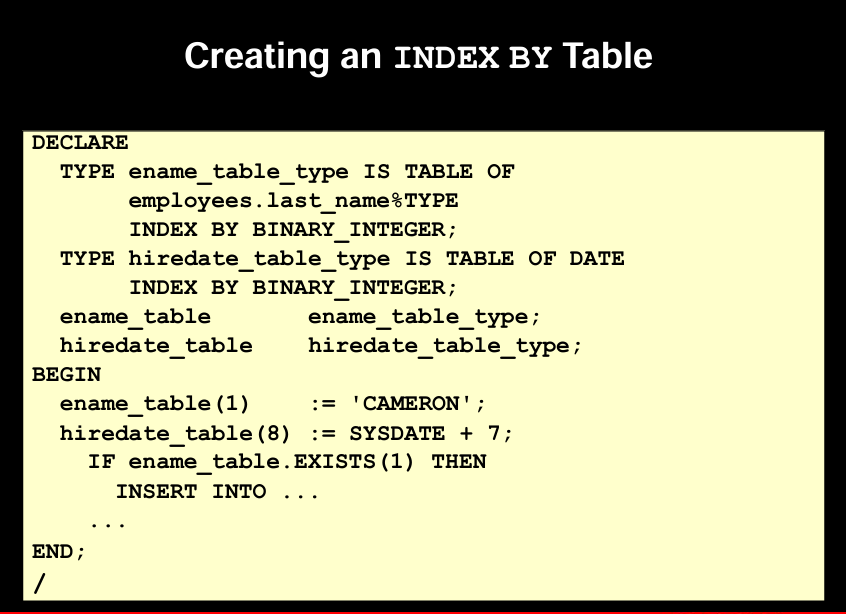
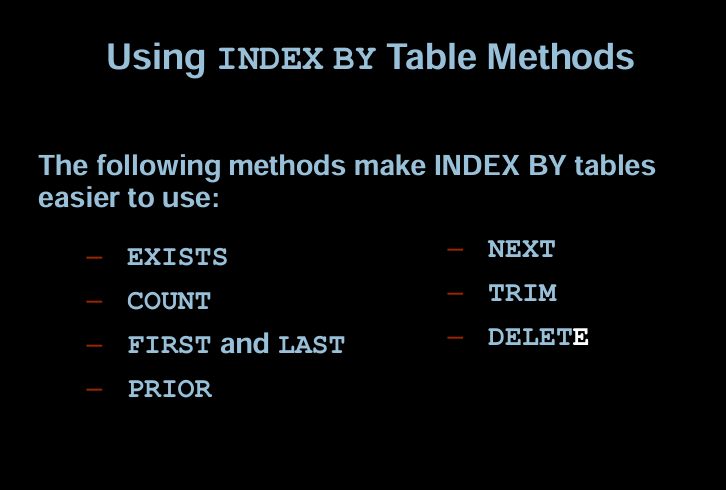

### using collection methods
- EXISTS
- COUNT
- LIMIT
- FIRST and LAST
- PRIOR and NEXT
- EXTEND
- TRIM
- DELETE

In [ ]:
-- Exists
DECLARE
   TYPE NumList IS TABLE OF INTEGER;
   n NumList := NumList(1,3,5,7);
BEGIN
   FOR I IN N.FIRST..N.LAST LOOP
   DBMS_OUTPUT.PUT_LINE(I || '-> '|| n(i));
   END LOOP;
   
   n.DELETE(2); -- Delete the second element
   IF n.EXISTS(1) THEN
      dbms_output.put_line('OK, element #1 exists.');
   END IF;
   IF n.EXISTS(2) = FALSE THEN
      dbms_output.put_line('OK, element #2 has been deleted.');
   END IF;
   IF n.EXISTS(99) = FALSE THEN
      dbms_output.put_line('OK, element #99 does not exist at all.');
   END IF;
END;
/

In [ ]:
DECLARE
   TYPE NumList IS TABLE OF NUMBER;
   n NumList := NumList(2,4,6,8); -- Collection starts with 4 elements.
BEGIN
   dbms_output.put_line('There are ' || n.COUNT || ' elements in N.');
   n.EXTEND(3); -- Add 3 new elements at the end.
   dbms_output.put_line('Now there are ' || n.COUNT || ' elements in N.');
   n := NumList(86,99); -- Assign a completely new value with 2 elements.
   dbms_output.put_line('Now there are ' || n.COUNT || ' elements in N.');
   n.TRIM(2); -- Remove the last 2 elements, leaving none.
   dbms_output.put_line('Now there are ' || n.COUNT || ' elements in N.');
END;
/

In [ ]:
DECLARE
   TYPE Colors IS VARRAY(7) OF VARCHAR2(64);
   c Colors := Colors('Gold','Silver');
BEGIN
   dbms_output.put_line('C has ' || c.COUNT || ' elements now.');
   dbms_output.put_line('C''s type can hold a maximum of ' || c.LIMIT || ' elements.');
   dbms_output.put_line('The maximum number you can use with C.EXTEND() is ' || (c.LIMIT - c.COUNT));
END;
/

- First and last

In [ ]:
DECLARE
   TYPE NumList IS TABLE OF NUMBER;
   n NumList := NumList(1,3,5,7);
   counter INTEGER;
BEGIN
   dbms_output.put_line('N''s first subscript is ' || n.FIRST);
   dbms_output.put_line('N''s last subscript is ' || n.LAST);

-- When the subscripts are consecutive starting at 1, it's simple to loop through them.
   FOR i IN n.FIRST .. n.LAST
   LOOP
      dbms_output.put_line('Element #' || i || ' = ' || n(i));
   END LOOP;

   n.DELETE(2); -- Delete second element.
-- When the subscripts have gaps or the collection might be uninitialized,
-- the loop logic is more extensive. We start at the first element, and
-- keep looking for the next element until there are no more.
   IF n IS NOT NULL THEN
      counter := n.FIRST;
      WHILE counter IS NOT NULL
      LOOP
         dbms_output.put_line('Element #' || counter || ' = ' || n(counter));
         counter := n.NEXT(counter);
      END LOOP;
   ELSE
      dbms_output.put_line('N is null, nothing to do.');
   END IF;
END;
/

- Looping Through Collection Elements (PRIOR and NEXT Methods)

In [ ]:
DECLARE
   TYPE NumList IS TABLE OF NUMBER;
   n NumList := NumList(1966,1971,1984,1989,1999);
BEGIN
   dbms_output.put_line('The element after #2 is #' || n.NEXT(2));
   dbms_output.put_line('The element before #2 is #' || n.PRIOR(2));
   n.DELETE(3); -- Delete an element to show how NEXT can handle gaps.
   dbms_output.put_line('Now the element after #2 is #' || n.NEXT(2));
   IF n.PRIOR(n.FIRST) IS NULL THEN
      dbms_output.put_line('Can''t get PRIOR of the first element or NEXT of the last.');
   END IF;
END;
/

You can use PRIOR or NEXT to traverse collections indexed by any series of subscripts. The following example uses NEXT to traverse a nested table from which some elements have been deleted:
```sql
DECLARE
   TYPE NumList IS TABLE OF NUMBER;
   n NumList := NumList(1,3,5,7);
   counter INTEGER;
BEGIN
   n.DELETE(2); -- Delete second element.
-- When the subscripts have gaps, the loop logic is more extensive. We start at the
-- first element, and keep looking for the next element until there are no more.
   counter := n.FIRST;
   WHILE counter IS NOT NULL
   LOOP
      dbms_output.put_line('Counting up: Element #' || counter || ' = ' || n(counter));
      counter := n.NEXT(counter);
   END LOOP;

-- Run the same loop in reverse order.
   counter := n.LAST;
   WHILE counter IS NOT NULL
   LOOP
      dbms_output.put_line('Counting down: Element #' || counter || ' = ' || n(counter));
      counter := n.PRIOR(counter);
   END LOOP;
END;
/
```

##### Trim
This procedure has two forms:

- TRIM removes one element from the end of a collection.

- TRIM(n) removes n elements from the end of a collection.
```sql
DECLARE
   TYPE NumList IS TABLE OF NUMBER;
   n NumList := NumList(1,2,3,5,7,11);
   PROCEDURE print_numlist(the_list NumList) IS
      output VARCHAR2(128);
   BEGIN
      IF n.COUNT = 0 THEN
         dbms_output.put_line('No elements in collection.');
      ELSE
         FOR i IN the_list.FIRST .. the_list.LAST
         LOOP
            output := output || NVL(TO_CHAR(the_list(i)),'NULL') || ' ';
         END LOOP;
         dbms_output.put_line(output);
      END IF;
   END;
BEGIN
   print_numlist(n);
   n.TRIM(2); -- Remove last 2 elements.
   print_numlist(n);
   n.TRIM; -- Remove last element.
   print_numlist(n);
   n.TRIM(n.COUNT); -- Remove all remaining elements.
   print_numlist(n);

-- If too many elements are specified, TRIM raises the exception SUBSCRIPT_BEYOND_COUNT.
   BEGIN
      n := NumList(1,2,3);
      n.TRIM(100);
      EXCEPTION
         WHEN SUBSCRIPT_BEYOND_COUNT THEN
            dbms_output.put_line('I guess there weren''t 100 elements that could be trimmed.');
   END;

-- When elements are removed by DELETE, placeholders are left behind. TRIM counts these
-- placeholders as it removes elements from the end.

   n := NumList(1,2,3,4);
   n.DELETE(3);  -- delete element 3
-- At this point, n contains elements (1,2,4).
-- TRIMming the last 2 elements removes the 4 and the placeholder, not 4 and 2.
   n.TRIM(2);
   print_numlist(n);
END;
/
END;
/
```

- If n is too large, TRIM(n) raises SUBSCRIPT_BEYOND_COUNT.